In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from toy_model import simulate_water_balance

# Validation

In [2]:
######################
# Select state
name = "illinois"
######################

T = np.loadtxt(f"./data/{name}_temperature.txt")
P = np.loadtxt(f"./data/{name}_precip.txt")
lai = np.loadtxt(f"./data/{name}_lai.txt")
soilMoist = np.loadtxt(f"./data/{name}_soilMoist.txt")
soilMoistFrac = np.loadtxt(f"./data/{name}_soilMoistFrac.txt")
Kc = np.loadtxt(f"./data/{name}_kc.txt")

# Select correct latitiude
# SD: [44,-98]
# IA: [42,-93]
# IL: [40,-89]
lat_dict = {"southdakota":44, "iowa":42, "illinois":40}
lat = lat_dict[name]

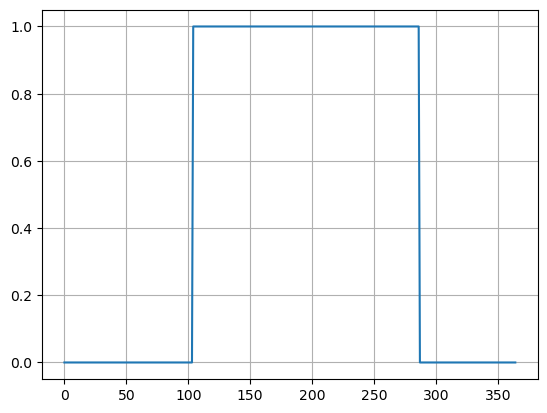

In [3]:
# When is the growing season defined?
growing_season = [1 if kc > 0. else 0. for kc in Kc]
gs_start = np.argwhere(np.array(growing_season) > 0)[0][0]
gs_end = np.argwhere(np.array(growing_season) > 0)[-1][0]

fig, ax = plt.subplots()
ax.plot(growing_season)
ax.grid()
plt.show()

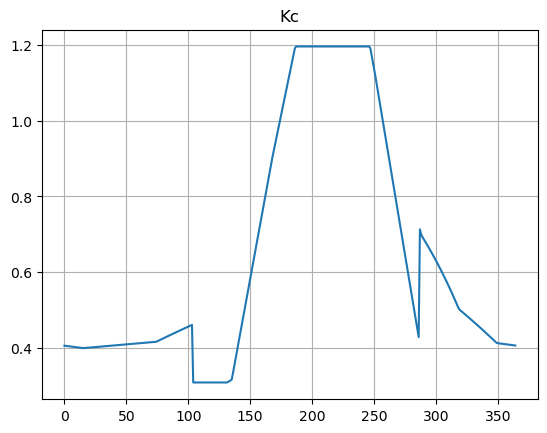

In [7]:
# Construct Kc timeseries outside growing season
def get_noGS_kc(t, lai):
    # Taken from WBM code (lines 1933, 5028 or search for KcMin) (no mention of this in docs)
    Kc_min = 0.2
    Kc_max = 1.1
    return Kc_min + (Kc_max - Kc_min) * (1 - np.exp(-0.7*lai))

Kc_final = [Kc[t] if Kc[t] > 0. else get_noGS_kc(t, lai[t]) for t in range(len(Kc))]

fig, ax = plt.subplots()
ax.plot(Kc_final)
ax.grid()
ax.set_title("Kc")
plt.show()

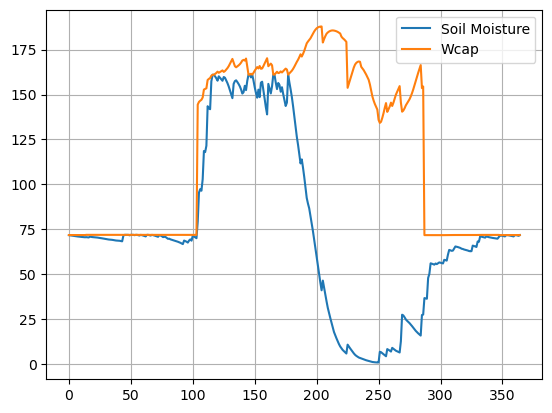

In [8]:
# Construct Wcap
Wcap_final = soilMoist/soilMoistFrac # calculate Wcap from WBM

fig, ax = plt.subplots()
ax.plot(soilMoist, label="Soil Moisture")
ax.plot(Wcap_final, label="Wcap")
ax.grid()
ax.legend()
plt.show()

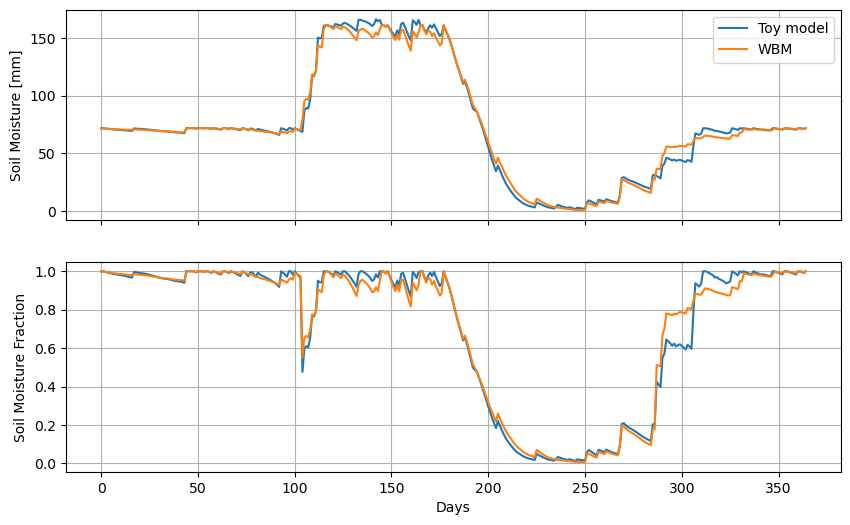

In [9]:
################
# Comparison 
################
# Parameters
alpha = 5.         # Soil drying coefficient
Ts = -1.          # Snowfall threshold
Tm = 1.           # Snowmelt threshold
s_c = 0.4          # Crop-specific threshold factor
r_I = 0.9          # Irrigation inefficiency factor
r_FI = 0.9         # Framer irrigation inefficiency factor (added by David to test some things, in WBM r_FI = 1)
r_p = 0.5          # Runoff-percolation partitioning factor
beta_HBV = -1      # HBV direct recharge parameter (-1 to turn off)
gamma_S = 0.5      # Soil moisture surplus coefficient
gamma_G = 0.0167   # Groundwater leakage coefficient
phi = lat          # Latitude

# Initial conditions
Ws_init = soilMoist[0]  # Initial soil moisture: take from WBM
Wi_init = 0.5           # Canopy water storage
Sp_init = 0             # Snowpack
Wg_init = 100000.       # Groundwater

# No spinup
Ws, Ws_frac, Wg = simulate_water_balance(spinup=1,
                                            Ws_init = Ws_init,
                                            Wi_init = Wi_init,
                                            Sp_init = Sp_init,
                                            Wg_init = Wg_init,
                                            P = P, 
                                            T = T, 
                                            Wcap_in = Wcap_final,
                                            Ts = Ts,
                                            Tm = Tm,
                                            lai = lai,
                                            Kc = Kc_final,
                                            alpha = alpha,
                                            s_c = s_c,
                                            r_I = r_I,
                                            r_FI = r_FI,
                                            r_p = r_p,
                                            beta_HBV = beta_HBV,
                                            gamma_S = gamma_S,
                                            gamma_G = gamma_G,
                                            phi=phi)

fig, axs = plt.subplots(2,1, figsize=(10,6), sharex=True)

# soilMoist
ax=axs[0]
ax.plot(Ws, label="Toy model")
ax.plot(soilMoist, label = "WBM")
ax.grid()
ax.set_ylabel("Soil Moisture [mm]")
ax.legend()

# soilMoistFrac
ax=axs[1]
ax.plot(Ws_frac, label="Toy model")
ax.plot(soilMoistFrac, label = "WBM")
ax.grid()
ax.set_ylabel("Soil Moisture Fraction")
ax.set_xlabel("Days")

plt.show()